<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>

Figure 1.1.a. Jupyter environment + Python notebooks

# Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

In [1]:
# # This cell is for papermill parameters. DO NOT CHANGE THE VARIABLE NAMES.
# # Default values for manual execution (papermill will override these)
# input_geojson_path = None
# output_csv_path = None

## Step 1.1: Configure the environment

In [33]:
import os
from datetime import datetime
from shapely.geometry import Polygon
from shapely import box
from pyproj import CRS 
import folium
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
import rioxarray
from ipyleaflet import basemaps
from numpy.lib.stride_tricks import sliding_window_view
import pystac_client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import planetary_computer
from odc.stac import load
from pystac.client import Client
from skimage.feature import graycomatrix, graycoprops
# from utils import load_data, scale, calculate_band_indices, apply_mask, mask_land, mask_deeps, mask_surf, mask_elevation, all_masks, glcm_features, do_prediction
import matplotlib.pyplot as plt
from odc.algo import binary_dilation
from skimage.morphology import disk
from utils import load_data, scale, calculate_band_indices, apply_mask, mask_land, mask_deeps, mask_elevation, all_masks, glcm_features, do_prediction

In [34]:
# Reload scripts and imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Predefined variable for title and version

# Enter your initials
initials = "nm"

# Enter your site name
site = "serua_revise"

# Date
date = datetime.now()

# Make a clean version string
version = f"{initials}-{site}-{date.strftime('%d%m%Y')}"
print(version)

nm-serua_revise-15082025


In [36]:
gdfs = []
postcards_path = "training-data/"
file_extension: str = ".geojson"

for filename in os.listdir(postcards_path):
    file_path = os.path.join(postcards_path, filename)
    if os.path.isfile(file_path) and filename.endswith(file_extension):
    # try:
        gdf = gpd.read_file(file_path)
        gdfs.append(gdf)

In [37]:
for filename in os.listdir(postcards_path):
    file_path = os.path.join(postcards_path, filename)
    if os.path.isfile(file_path) and filename.endswith(file_extension):
        print(filename) # This line will print the name of each GeoJSON file
        # The rest of your code to read the file and append to gdfs
        # gdf = gpd.read_file(file_path)
        # gdfs.append(gdf)

print("\nFinished listing GeoJSON files.")

serua_revise_postcard.geojson
serua_postcard.geojson

Finished listing GeoJSON files.


## Step 1.2: Configure STAC access and search parameters

In [38]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [39]:
# filename = "nm-efate-27072025_postcard.geojson"

In [40]:
training = gpd.read_file(f"training-data/{site}_postcard.geojson")
training = training.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = training.total_bounds

bbox = [min_lon, min_lat, max_lon, max_lat]

In [41]:
datetime = "2024"

items = client.search(
    collections=["dep_s2_geomad"],
    datetime=datetime,
    bbox=bbox
).item_collection()

print(f"Found {len(items)} items in for {datetime}")

Found 1 items in for 2024


In [42]:
measurements = ["nir", "red", "blue", "green", "emad", "smad", "bcmad", "green", "nir08", "nir09", "swir16", "swir22", "coastal", "rededge1", "rededge2", "rededge3"]
data = load_data(
    items,
    measurements,
    bbox,
)
    
# Now you can use the 'data' variable
print(data)

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 161, x: 189, time: 1)
Coordinates:
  * y            (y) float64 1kB -2.053e+06 -2.053e+06 ... -2.055e+06 -2.055e+06
  * x            (x) float64 2kB 3.097e+06 3.097e+06 ... 3.099e+06 3.099e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/15)
    nir          (time, y, x) uint16 61kB dask.array<chunksize=(1, 161, 189), meta=np.ndarray>
    red          (time, y, x) uint16 61kB dask.array<chunksize=(1, 161, 189), meta=np.ndarray>
    blue         (time, y, x) uint16 61kB dask.array<chunksize=(1, 161, 189), meta=np.ndarray>
    green        (time, y, x) uint16 61kB dask.array<chunksize=(1, 161, 189), meta=np.ndarray>
    emad         (time, y, x) float32 122kB dask.array<chunksize=(1, 161, 189), meta=np.ndarray>
    smad         (time, y, x) float32 122kB dask.array<chunksize=(1, 161, 189), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) uint16 61kB dask.array<ch

In [43]:
dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
configure_s3_access(cloud_defaults=True, requester_pays=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32773 instead
  warnings.warn(


In [44]:
scaled = scale(data)
scaled = scaled.compute().squeeze()

In [45]:
# Explore the site we are working on
scaled.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [46]:
scaled

<xarray.Dataset> Size: 3MB
Dimensions:      (y: 161, x: 189)
Coordinates:
  * y            (y) float64 1kB -2.053e+06 -2.053e+06 ... -2.055e+06 -2.055e+06
  * x            (x) float64 2kB 3.097e+06 3.097e+06 ... 3.099e+06 3.099e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/15)
    nir          (y, x) float64 243kB 0.0291 0.0257 0.0279 ... 0.029 0.0293
    red          (y, x) float64 243kB 0.0603 0.0571 0.0594 ... 0.0728 0.0706
    blue         (y, x) float64 243kB 0.1163 0.1103 0.1106 ... 0.11 0.1116
    green        (y, x) float64 243kB 0.1345 0.1252 0.1265 ... 0.1299 0.1304
    emad         (y, x) float32 122kB 0.08257 0.07723 ... 0.08424 0.08516
    smad         (y, x) float32 122kB 4.52e-06 5.398e-06 ... 2.932e-06 3.009e-06
    ...           ...
    swir16       (y, x) float64 243kB 0.0256 0.022 0.024 ... 0.0291 0.0291
    swir22       (y, x) float64 243kB 0.0245 0.0212 0.0231 ... 0.0283 0.0284
    coastal      (y, x) float64 243kB 0.0939 0.0874 0.0888 ... 0.0939 0.094
    rededge1     (y, x) float64 243kB 0.0485 0.0449 0.0472 ... 0.0675 0.0674
    rededge2     (y, x) float64 243kB 0.0295 0.0258 0.028 ... 0.0329 0.0329
    rededge3     (y, x) float64 243kB 0.0309 0.0278 0.03 ... 0.0399 0.035 0.0351

In [47]:
scaled = calculate_band_indices(scaled)
Dataset = scaled

### GLCM texture analysis

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [48]:
WINDOW_SIZE = 9
LEVELS = 32

# Input
max = scaled.blue.max().values
min = scaled.blue.min().values
# Scale to 0-LEVELS for GLCM
img = ((scaled.blue - min) / (max - min) * (LEVELS - 1)).clip(0, LEVELS - 1).values.astype(np.uint8)

# Extract overlapping windows
patches = sliding_window_view(img, (WINDOW_SIZE, WINDOW_SIZE))
# Shape: (rows, cols, win_y, win_x)


In [49]:
import numpy as np # Ensure numpy is imported if not already

# Assuming 'patches' is a 4D NumPy array with dimensions (y_coords, x_coords, window_y_size, window_x_size)
# To get the first patch (at y=0, x=0), you would index it like this:
sample_patch_data = patches[0, 0, :, :]

# Verify the shape of the extracted sample patch data
print(f"Shape of sample_patch_data: {sample_patch_data.shape}")

# Call glcm_features directly on this 2D sample data
sample_result = glcm_features(sample_patch_data)

# Print the shape of the result to get the number of features
print(f"Shape of glcm_features output for a single patch: {sample_result.shape}")

Shape of sample_patch_data: (9, 9)
Shape of glcm_features output for a single patch: (7,)


In [50]:
# Use apply_ufunc to vectorize over (row, col) dimensions
result = xr.apply_ufunc(
    glcm_features,
    xr.DataArray(patches, dims=["y", "x", "win_y", "win_x"]),
    input_core_dims=[["win_y", "win_x"]],
    output_core_dims=[["feature"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.float32]
)

# Add coordinates & names
pad = WINDOW_SIZE - 1
result = result.assign_coords({
    "y": scaled.y[: -pad],
    "x": scaled.x[: -pad],
    "feature": ["contrast", "homogeneity", "energy", "ASM", "correlation", "mean", "entropy"]
})

result_bands = result.to_dataset(dim="feature")

# Combine with original
combined = scaled.copy()
combined = combined.assign(result_bands)

combined

<xarray.Dataset> Size: 7MB
Dimensions:      (y: 161, x: 189)
Coordinates:
  * y            (y) float64 1kB -2.053e+06 -2.053e+06 ... -2.055e+06 -2.055e+06
  * x            (x) float64 2kB 3.097e+06 3.097e+06 ... 3.099e+06 3.099e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir          (y, x) float64 243kB 0.0291 0.0257 0.0279 ... 0.029 0.0293
    red          (y, x) float64 243kB 0.0603 0.0571 0.0594 ... 0.0728 0.0706
    blue         (y, x) float64 243kB 0.1163 0.1103 0.1106 ... 0.11 0.1116
    green        (y, x) float64 243kB 0.1345 0.1252 0.1265 ... 0.1299 0.1304
    emad         (y, x) float32 122kB 0.08257 0.07723 ... 0.08424 0.08516
    smad         (y, x) float32 122kB 4.52e-06 5.398e-06 ... 2.932e-06 3.009e-06
    ...           ...
    homogeneity  (y, x) float32 122kB 0.7917 0.8056 0.7694 ... nan nan nan
    energy       (y, x) float32 122kB 0.4821 0.4654 0.429 0.4209 ... nan nan nan
    ASM          (y, x) float32 122kB 0.2324 0.2166 0.184 0.1772 ... nan nan nan
    correlation  (y, x) float32 122kB 0.4398 0.5314 0.4221 ... nan nan nan
    mean         (y, x) float32 122kB 9.944 9.792 9.708 9.625 ... nan nan nan
    entropy      (y, x) float32 122kB 2.47 2.552 2.782 2.886 ... nan nan nan nan

In [51]:
combined.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [52]:
masked_combined, mask = all_masks(combined, return_mask = True)
mask.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [53]:
masked_combined.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site, tiles=basemaps.Esri.WorldImagery)

/srv/conda/envs/notebook/lib/python3.10/site-packages/odc/geo/_rgba.py:55: RuntimeWarning: invalid value encountered in cast
  return x.astype("uint8")


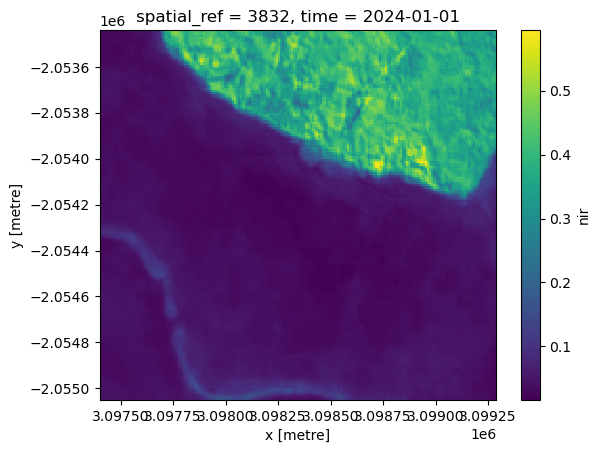

In [54]:
combined.nir.plot()

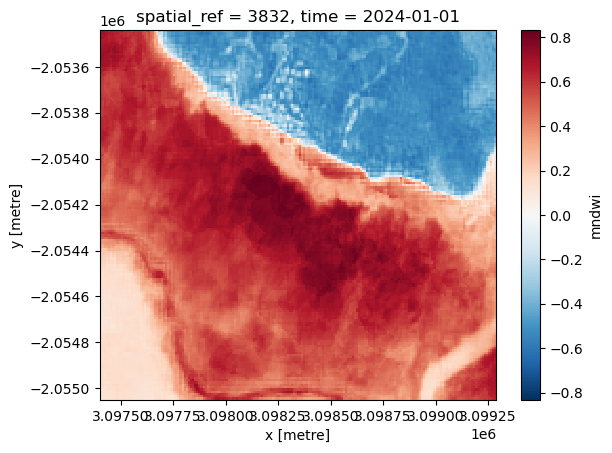

In [55]:
combined.mndwi.plot()

In [56]:
combined

<xarray.Dataset> Size: 7MB
Dimensions:      (y: 161, x: 189)
Coordinates:
  * y            (y) float64 1kB -2.053e+06 -2.053e+06 ... -2.055e+06 -2.055e+06
  * x            (x) float64 2kB 3.097e+06 3.097e+06 ... 3.099e+06 3.099e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir          (y, x) float64 243kB 0.0291 0.0257 0.0279 ... 0.029 0.0293
    red          (y, x) float64 243kB 0.0603 0.0571 0.0594 ... 0.0728 0.0706
    blue         (y, x) float64 243kB 0.1163 0.1103 0.1106 ... 0.11 0.1116
    green        (y, x) float64 243kB 0.1345 0.1252 0.1265 ... 0.1299 0.1304
    emad         (y, x) float32 122kB 0.08257 0.07723 ... 0.08424 0.08516
    smad         (y, x) float32 122kB 4.52e-06 5.398e-06 ... 2.932e-06 3.009e-06
    ...           ...
    homogeneity  (y, x) float32 122kB 0.7917 0.8056 0.7694 ... nan nan nan
    energy       (y, x) float32 122kB 0.4821 0.4654 0.429 0.4209 ... nan nan nan
    ASM          (y, x) float32 122kB 0.2324 0.2166 0.184 0.1772 ... nan nan nan
    correlation  (y, x) float32 122kB 0.4398 0.5314 0.4221 ... nan nan nan
    mean         (y, x) float32 122kB 9.944 9.792 9.708 9.625 ... nan nan nan
    entropy      (y, x) float32 122kB 2.47 2.552 2.782 2.886 ... nan nan nan nan

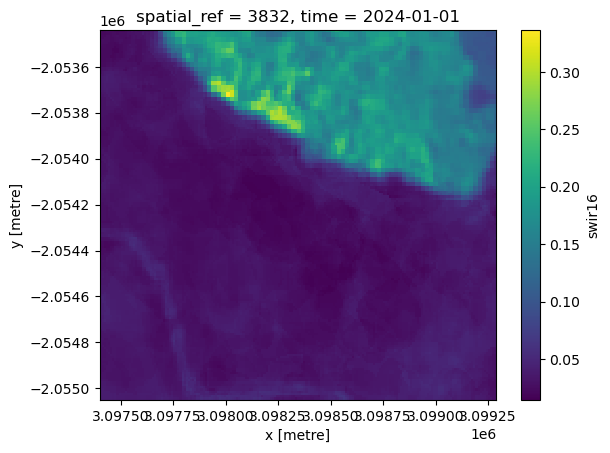

In [57]:
swir_mask = (combined.swir16).plot()

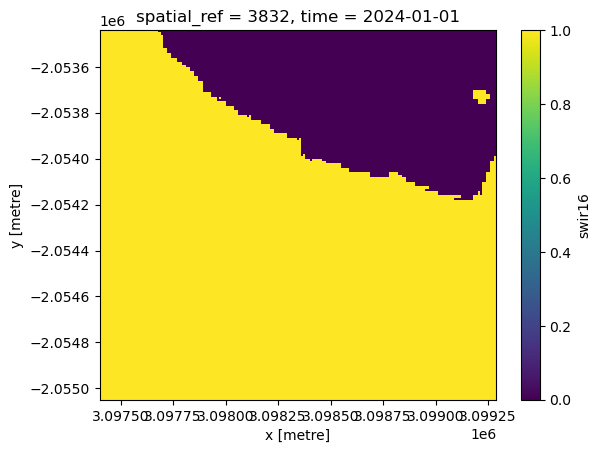

In [58]:
swir_mask = (combined.swir16 < 0.08).plot()

In [59]:
swir_mask = (combined.swir16 < 0.06)

In [60]:
swir_mask = swir_mask.astype('uint8')
swir_mask.odc.write_cog("swir_mask.tif", overwrite=True)

PosixPath('swir_mask.tif')

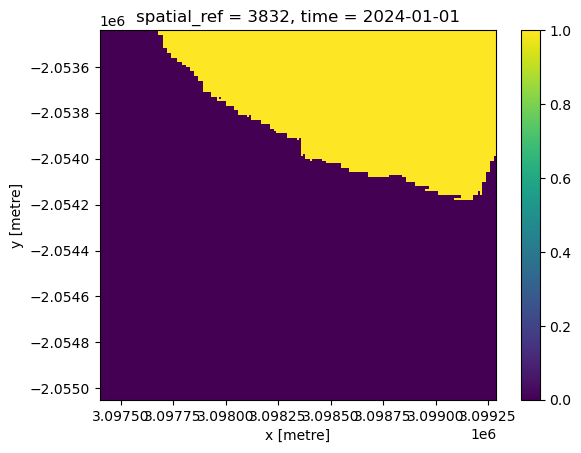

In [61]:
swir_mask = (combined.swir16 > 0.08)

land_threshold = -0.2
land_mask = (combined.mndwi<land_threshold).squeeze()

swir_mask = swir_mask.astype(bool)
land_mask = land_mask.astype(bool)

land_mask = land_mask + swir_mask
land_mask.plot()

In [62]:
# surf_mask = surf_mask & water_mask
# surf_mask.plot()

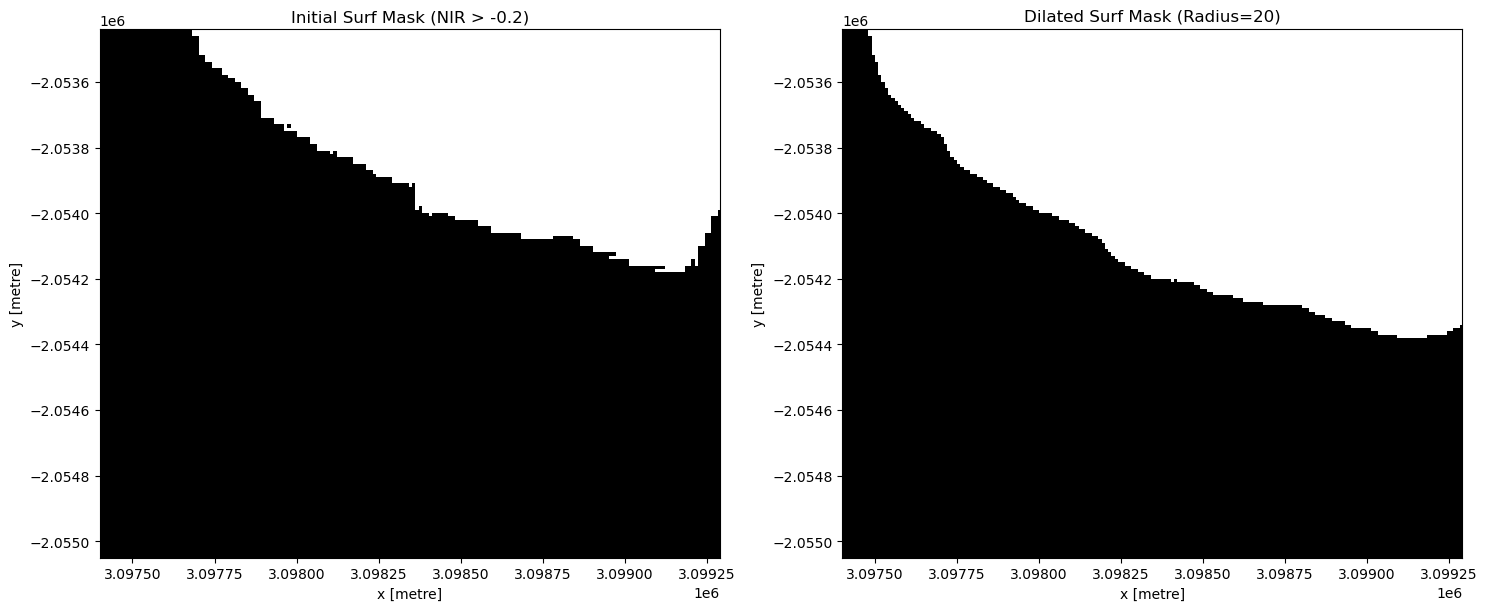

In [70]:
land_mask = land_mask.chunk({'x': 512, 'y': 512})

land_mask = land_mask.astype(bool)
land_dilation_radius = 20


dilated_land_mask = binary_dilation(land_mask, radius=land_dilation_radius)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot Initial Mask
land_mask.plot.imshow(
    ax=axes[0],
    cmap='gray', # 'gray' or 'Greys_r' are good for binary masks
    add_colorbar=False
)
axes[0].set_title(f'Initial Surf Mask (NIR > {land_threshold})')
axes[0].set_aspect('equal', adjustable='box')


# Plot Dilated Mask
dilated_land_mask.plot.imshow(
    ax=axes[1],
    cmap='gray', # Use the same colormap for comparison
    add_colorbar=False,
)
axes[1].set_title(f'Dilated Surf Mask (Radius={land_dilation_radius})')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [71]:
# # Assuming dilated_land_mask is your xarray.DataArray (boolean type)
# dilated_land_mask = dilated_land_mask.astype('uint8')

# dilated_land_mask.odc.write_cog("dilated_mask.tif", overwrite=True)

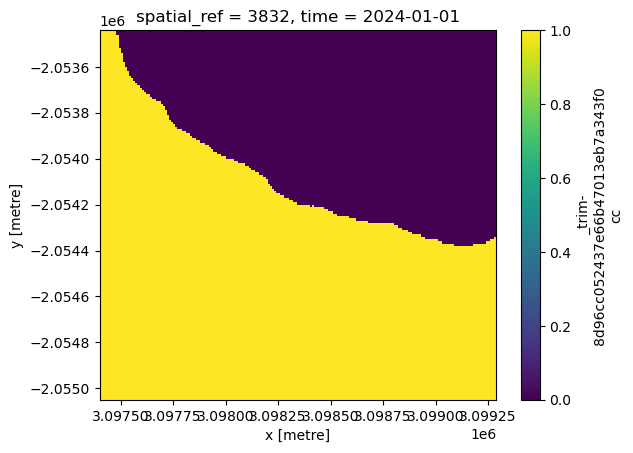

In [72]:

dilated_land_mask = dilated_land_mask.astype(bool)

water_mask = ~dilated_land_mask

water_mask.plot()


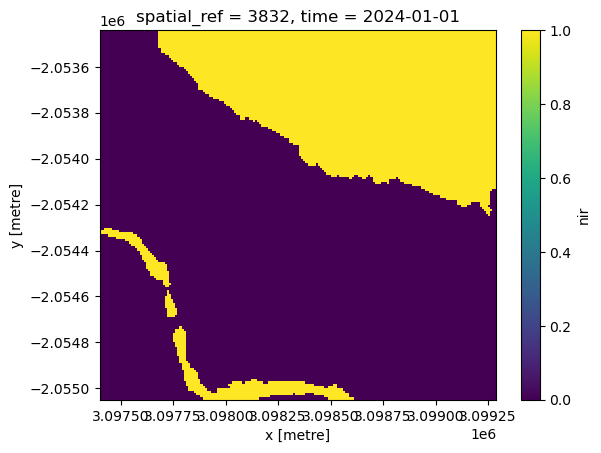

In [73]:

# from scipy.ndimage import binary_dilation
surf_threshold = 0.08

surf_mask = combined.nir > surf_threshold
# surf_mask = combined.nir.where(combined.nir<surf_threshold).squeeze()
# surf_mask = ~surf_mask
# surf_mask = combined.nir.where(surf_threshold)
surf_mask.plot()

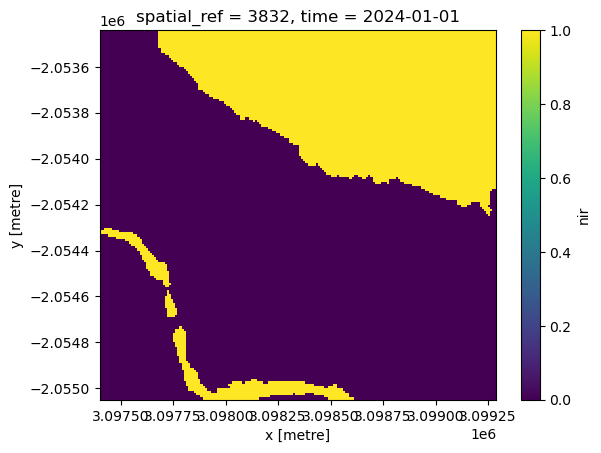

In [74]:
surf_mask = surf_mask.astype(bool)
surf_mask.plot()


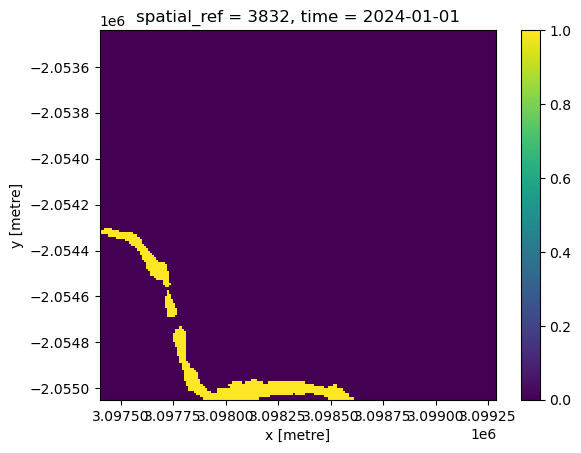

In [75]:
surf_mask = surf_mask & water_mask
surf_mask.plot()

In [76]:
# surf_mask = surf_mask.astype('uint8')
# surf_mask.odc.write_cog("surf_mask.tif", overwrite=True)

In [77]:
surf_mask

<xarray.DataArray (y: 161, x: 189)> Size: 30kB
dask.array<bitwise_and, shape=(161, 189), dtype=bool, chunksize=(161, 189), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1kB -2.053e+06 -2.053e+06 ... -2.055e+06 -2.055e+06
  * x            (x) float64 2kB 3.097e+06 3.097e+06 ... 3.099e+06 3.099e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01

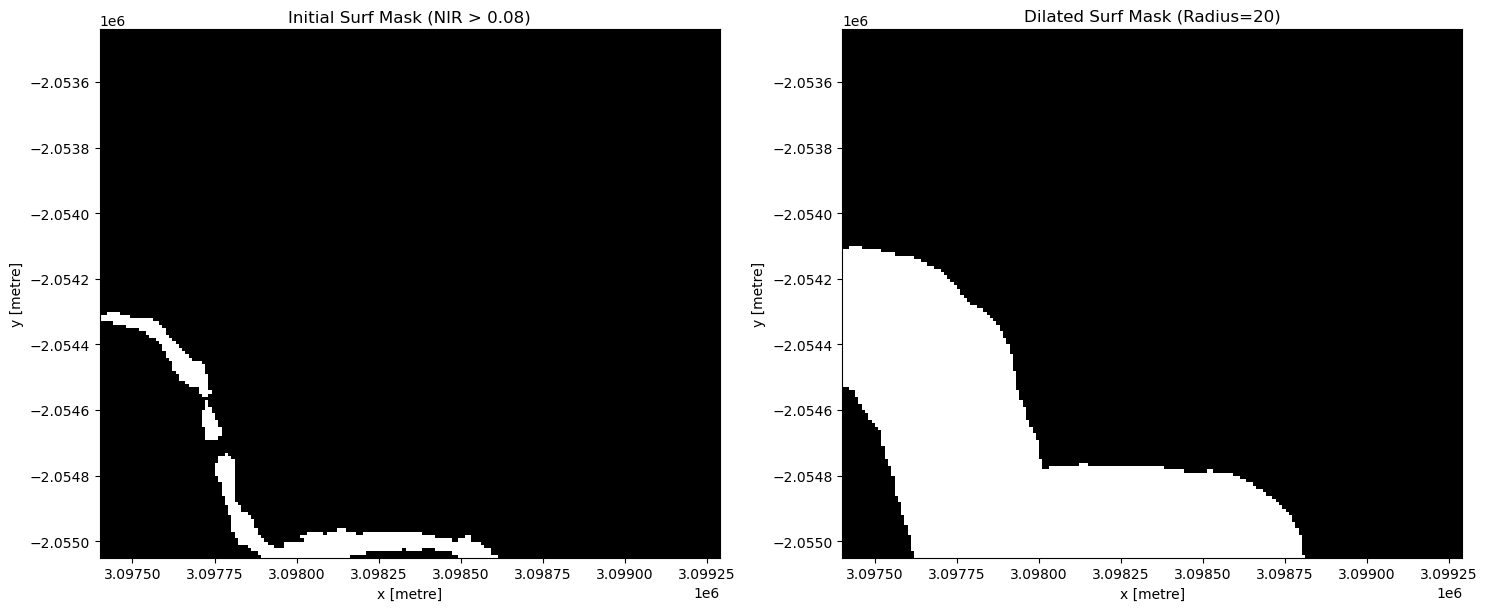

In [78]:

surf_mask = surf_mask.chunk({'x': 512, 'y': 512})

surf_mask = surf_mask.astype(bool)
surf_dilation_radius = 20


dilated_surf_mask = binary_dilation(surf_mask, radius=surf_dilation_radius)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot Initial Mask
surf_mask.plot.imshow(
    ax=axes[0],
    cmap='gray', # 'gray' or 'Greys_r' are good for binary masks
    add_colorbar=False
)
axes[0].set_title(f'Initial Surf Mask (NIR > {surf_threshold})')
axes[0].set_aspect('equal', adjustable='box')


# Plot Dilated Mask
dilated_surf_mask.plot.imshow(
    ax=axes[1],
    cmap='gray', # Use the same colormap for comparison
    add_colorbar=False
)
axes[1].set_title(f'Dilated Surf Mask (Radius={surf_dilation_radius})')
axes[1].set_aspect('equal', adjustable='box')


plt.tight_layout()
plt.show()


In [83]:
masked_combined.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

/srv/conda/envs/notebook/lib/python3.10/site-packages/odc/geo/_rgba.py:55: RuntimeWarning: invalid value encountered in cast
  return x.astype("uint8")


### Postcard csv

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [ ]:
# Reproject training data to the GeoMAD CRS and convert to xarray
training_reprojected = training.to_crs(masked_combined.odc.crs)
training_da = training_reprojected.assign(
    x=training_reprojected.geometry.x, y=training_reprojected.geometry.y
).to_xarray()

# Extract training values from the masked dataset
training_values = (
    masked_combined.sel(training_da[["x", "y"]], method="nearest")
    .squeeze()
    .compute()
    .to_pandas()
)
training_values

In [ ]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training["cc_id"], training_values], axis=1)

# Drop rows where there was no data available
training_array = training_array.dropna()

# Preview our resulting training array
training_array.head()

In [ ]:
print(training_array.shape[1], 'total columns')
print('columns included', training_array.columns)

In [ ]:
standard_schema = ['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'mndwi', 'ndti', 'cai', 'ndvi', 'evi', 'savi',
       'ndwi', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'contrast', 'homogeneity',
       'energy', 'ASM', 'correlation', 'mean', 'entropy', 'y', 'x', 'time',
       'spatial_ref']

In [ ]:
training_array=training_array[standard_schema]

In [ ]:
training_array=training_array.drop(columns=["spatial_ref", "time"])

In [ ]:
# Write the training data to a CSV file
training_array.to_csv(f"training-data/csvs/{version}-training.csv", index=False)

In [ ]:
training_array["cc_id"].dtype